In [1]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from skimage import io, img_as_ubyte
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing as preproc
import py_pcha
from sklearn.neighbors import KNeighborsClassifier
import random


import seaborn as sns

In [2]:
# Globals
_SEED = 0

In [3]:
# Set the paths for image files, labels etc
faces_path = "../data/Faces/"
labels_path = "../data/labels.csv"
names_path = "../data/filenames.txt"

In [4]:
# Read labels as pandas object from labels.csv
labels_columns = ['age', 'gender', 'race']
labels = pd.read_csv(labels_path)
labels = pd.DataFrame(data=labels.values, columns=labels_columns)

In [5]:
# filter labels
def filter_by_age(df, fromAge, toAge):
    return df[(df.age >= fromAge) & (df.age <=toAge)]

In [6]:
filtered_labels = filter_by_age(labels, 15, 40)

In [7]:
# Open a random image to get dimensions
test_img_name = 0
test_img = io.imread(faces_path+f"{test_img_name}.jpg", as_gray=True)
h, w = test_img.shape
del test_img

In [8]:
X = np.empty((len(filtered_labels), h*w))

for i, index in enumerate(filtered_labels.index):
    #print(i,index)
    a = io.imread(faces_path+f"{index}.jpg", as_gray=True)
    a = img_as_ubyte(a)
    X[i, :] = a.reshape(1, -1)
    
del a
print('Done loading images')

Done loading images


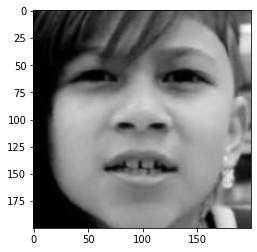

In [9]:
plt.imshow((X[0,:]).reshape(h,w), cmap='gray')

In [10]:
n_components = 49 # num components
k = 5 # number of nearest neighbours
knn = KNeighborsClassifier(n_neighbors=k)

In [11]:
y = filtered_labels["race"]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25, random_state=42, shuffle=True)


In [12]:
n, p = np.shape(Xtrain)
n

10011

In [13]:
#Archetypal analysis
# Does not require that you center data
XC, S, C, SSE, varexpl = py_pcha.PCHA(Xtrain.T, noc=n_components, delta=0.1)
X_hat = Xtrain.T @ C @ S
L = 0.5*np.linalg.norm(Xtrain.T-X_hat)**2
components = XC.T

knn.fit(S.T,ytrain)
Xtest_transform = np.linalg.lstsq(XC, Xtest.T)[0] #solve Xtest = XC @ S for S
acc = knn.score(Xtest_transform.T,ytest)
X_test_hat = (XC @ Xtest_transform).T

#Reference to book notation
#XC = H transposed
#S = W (transposed, i suppose)
#SSE = Sum of Squared Errors




C:\Users\pf259\AppData\Local\Temp/ipykernel_18568/3808722314.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Xtest_transform = np.linalg.lstsq(XC, Xtest.T)[0] #solve Xtest = XC @ S for S


In [14]:
#Convert PCHA output to nicer matrices
B = C.T
W = S.T

In [15]:
#Get indexes of the samples more significant for the archetypes
Xmain = np.zeros((n_components,3))

for i in range(len(B)):
    Xmain[i,:] = np.flip(np.argsort(B[i]))[0,:3]
Xmain = Xmain.astype(int)
for i, sample in enumerate(Xmain[0]):
    print(Xtrain[sample,:])

[253. 253. 253. ... 189. 189. 189.]
[189. 191. 196. ... 245. 245. 245.]
[248. 248. 248. ... 248. 251. 254.]


In [16]:
B[6,(608, 474, 213)]

matrix([[0., 0., 0.]])

In [17]:
Xmain[6]

array([5112,  733, 6233])

In [18]:
#Helper functions
n_rows = 7 #for plotting
n_cols = 7 #for plotting

left = 0.0
right = 0.0
bottom = 0.99
top = 0.83
wspace = 0.0
hspace = 0.0
image_shape = (h, w)
# Function for plotting images
def plot_components(title, components):
    plt.figure(figsize=(2. * n_cols, 2.26 * n_rows))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    start_index = random.randint(0, n)
    for i, comp in enumerate(components):
        plt.subplot(n_rows, n_cols, i + 1)
        # normalize colormap
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        # Remove ticks from plot
        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)
    
def plot_recons(X, title, Nplot=100):
    plt.figure(figsize=(2. * 10, 2.26 * 10))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        # normalize colormap
        idx = random.randint(0, 210)
        comp = X[idx,:]
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        # Remove ticks from plot
        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)
    
def plot_arch_contributors(title, Xmain):
    '''
    Plot the three most representative samples that constitute each archetype
    '''
    plt.figure(figsize=(2. * n_components, 2.26 * np.shape(Xmain)[1]))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    start_index = random.randint(0, n)
    pos = 0
    for j in range(len(Xmain)):  
        for i, sample in enumerate(Xmain[j]):
            pos += 1
            comp = Xtrain[sample,:]
            plt.subplot(n_components, np.shape(Xmain)[1], pos)
            # normalize colormap
            vmax = max(comp.max(), -comp.min())
            plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                       interpolation='nearest',
                       vmin=-vmax, vmax=vmax)
            # Remove ticks from plot
            plt.xticks(())
            plt.yticks(())

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)

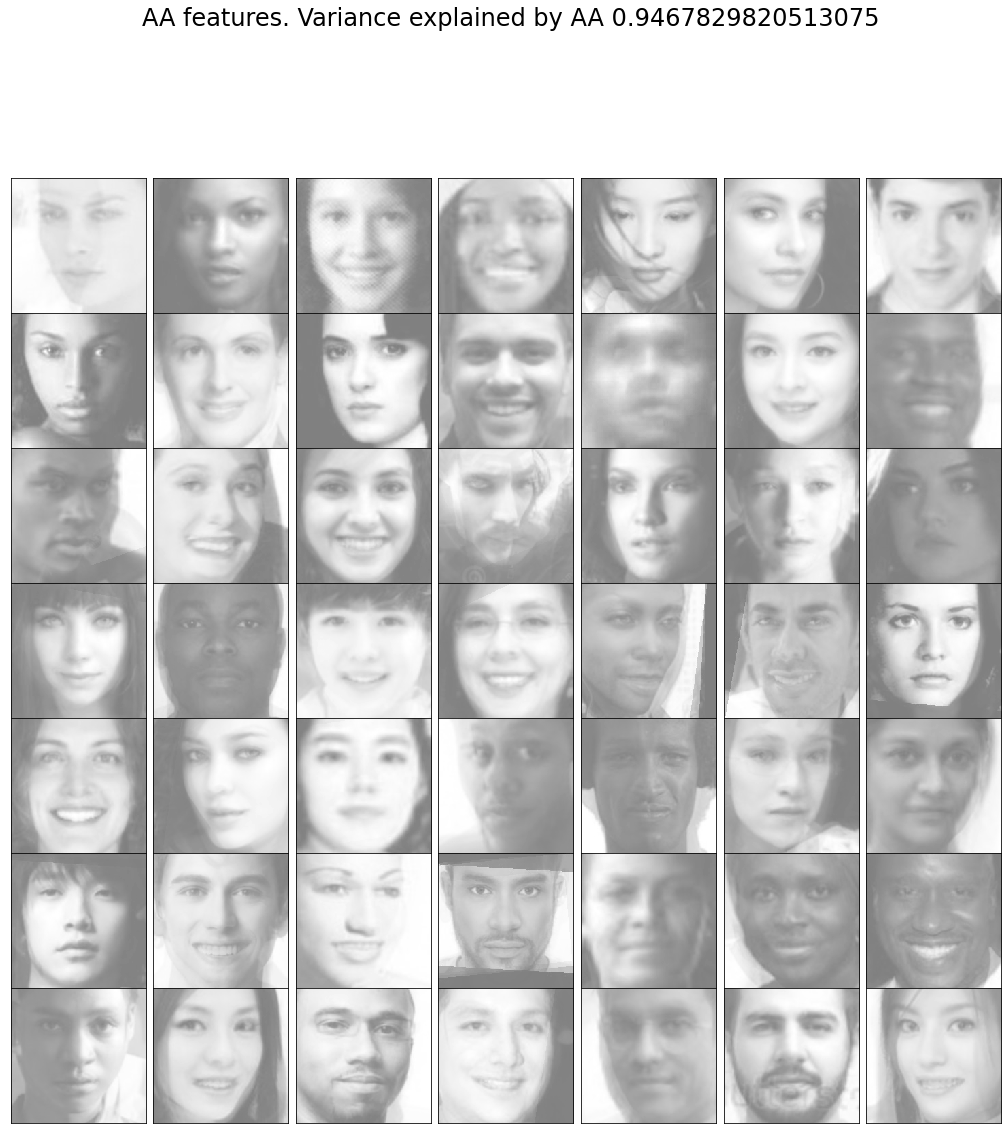

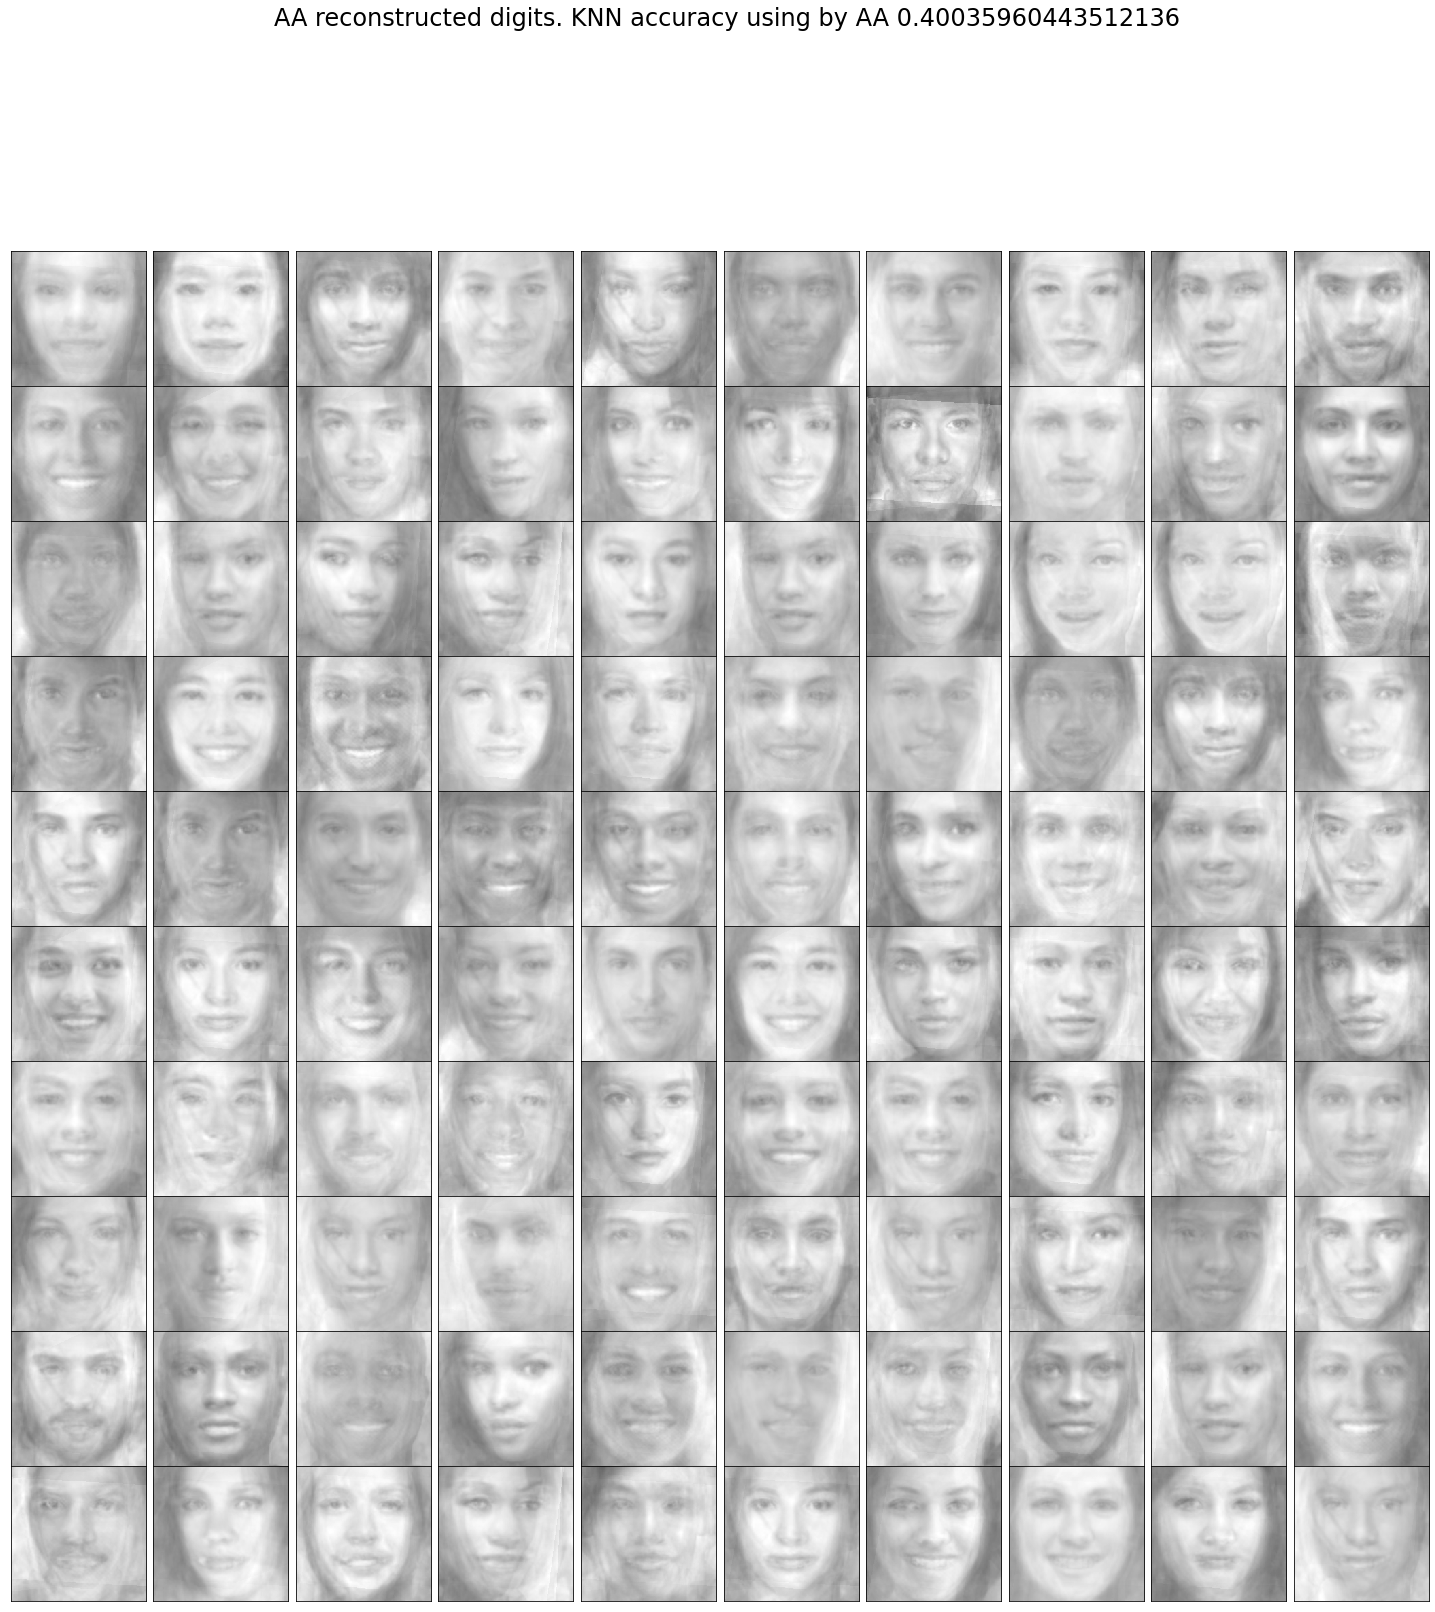

In [19]:
method = "AA"
SST = np.sum(np.sum(Xtrain**2))

plot_components(f'{method} features. Variance explained by {method} {1-2*L/SST}', components)
plot_recons(X_test_hat, f'{method} reconstructed digits. KNN accuracy using by {method} {acc}')

In [20]:
#Plot the main contributors for an archetype
    #Add the archetype to the function
#Plot the original image to the center. To the left increase the contribution of the first archetype. To the right the second (plot 5 images for example)
    #xi = wi * H
    #w_index1 = index of the main arhcetype, 2_index2 = index of the second archetype
    #transformed_face = vector of len 5. stolen = sum( percentage * wi[>0]. Update values

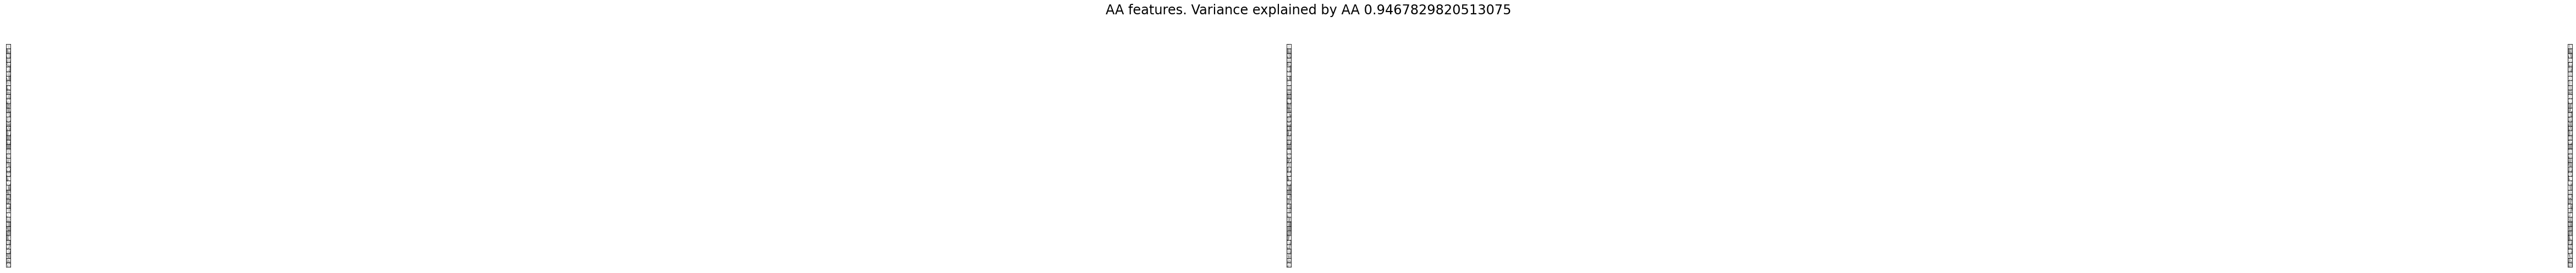

In [21]:
method = "AA"
SST = np.sum(np.sum(Xtrain**2))

plot_arch_contributors(f'{method} features. Variance explained by {method} {1-2*L/SST}', Xmain)
